### Ben Morton 25088718
### Nicholas Lombard 26210827

# Data Preprocessing

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import string
import nltk
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from langdetect import detect, LangDetectException, DetectorFactory
from nltk.corpus import words as nltk_words
from nltk.corpus import wordnet

In [5]:
# Load the dataset
df = pd.read_csv('Spotify.csv')

# Remove rows with missing values
df_cleaned = df.dropna()

# Remove rows with 5 or fewer characters in the "content" column
df_cleaned = df_cleaned[df_cleaned['content'].str.len() > 10]

# Ensure consistent results by setting a seed
DetectorFactory.seed = 0

# Initialize tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Combine NLTK words and WordNet lemmas
english_words = set(w.lower() for w in nltk_words.words())
wordnet_words = set(lemma.name().lower() for synset in wordnet.all_synsets() for lemma in synset.lemmas())
english_words.update(wordnet_words)

# Add custom words that are missing
custom_words = {
    'app', 'spotify', 'shuffled', 'seems', 'songs', 'anytime', 'favourite',
    'sporify', 'tiktok', 'vibes', 'promotes', 'trending', 'fits'
}
english_words.update(custom_words)

def clean_and_filter_text(text):

    # Replace common abbreviations or slang
    replacements = {
        r'\bu\b': 'you',
        r'\br\b': 'are',
        r'\bthx\b': 'thanks',
        r'\bidk\b': "i don't know",
        r'\baap\b': 'app',
        r'\bad\b': 'advertisement',
        r'\bads\b': 'advertisement'
    }
    for pattern, repl in replacements.items():
        text = re.sub(pattern, repl, text)

    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove emojis and non-ASCII characters
    text = text.encode('ascii', 'ignore').decode('ascii')

    # Rejoin the filtered words into a cleaned string
    return text

# Apply the cleaning function
df_cleaned['content'] = df_cleaned['content'].apply(clean_and_filter_text)

def is_majority_english(text, threshold=0.6):
    try:
        # Tokenize the text into words
        words = word_tokenize(text.lower())
        
        # Detect the predominant language using langdetect
        detected_language = detect(text)

        # If the language is already detected as English, return True
        if detected_language == 'en':
            return True
        
        # Count English words and calculate the proportion of English words
        english_count = sum(1 for word in words if word in english_words)
        proportion_english = english_count / max(len(words), 1) # Avoid division by zero

        # Retain the review if the proportion of English words meets the threshold
        return proportion_english >= threshold
    except LangDetectException:
        # Handle exceptions gracefully (e.g., very short or empty text)
        return False

# Apply the enhanced language detection function
df_cleaned = df_cleaned[df_cleaned['content'].apply(is_majority_english)] 
df_cleaned.head()

,reviewId,content,score
0,eefa199f-9a13-42e6-a9a7-14037134d694,So much software to improve but nothing has ch...,1
1,cda50701-da48-4325-87ce-3f9d27763fa0,Now the app keeps stopping for no reason,1
2,8b659206-b28a-4c83-9d39-95ca4e809781,Yay you fixed it,4
3,7457a06e-1627-4d08-90e1-20217dce2b59,Apss boring,1
4,5e660d6e-cae6-44cc-bebd-edda574b4e23,"Expensive as hell, to just listen to music BUT...",4


# Topic Modeling

In [6]:
# Custom stopwords ()
domain_stop_words = {
    'music', 'listen', 'listening', 'use', 'using', 'good', 'great', 'best', 'better',
    'need', 'really', 'like', 'app', 'spotify', 'love', 'awesome', 'amazing', 'thank',
    'much', 'ever', 'always', 'nice', 'excellent', 'one', 'get', 'dont', 'even', 'cant',
    'worst', 'many', 'hai', 'way', 'thing', 'want', 'de', 'ko', 'gon', 'bad', 'ok', 'que',
    'en', 'e', 'thanks', 'dis', 'wa', 'doe', 'song', 'play', 'ha', 'enjoy', '30', 'una', 
    'le', 'es', 'muy', 'pero', 'bekar', 'jata', 'kar', 'lagu', 'di','im','ive','na',
    'wan','lo','bien','estrellas','us','canciones','solo','5','however','tho','da','adda'
}

custom_stop_words = stop_words | domain_stop_words

# Function to check if a word is in the English dictionary
def is_english_word(word):
    return word.lower() in english_words

# Function to clean and filter text
def clean_and_filter_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize the text into words
    words_list = word_tokenize(text)

    # Lemmatize words
    words_list = [lemmatizer.lemmatize(word) for word in words_list]
    
    # Filter out non-English words
    filtered_words = [word for word in words_list if word not in custom_stop_words]


    '''    # Filter out non-English words
    filtered_words = [word for word in words_list if is_english_word(word) and word not in custom_stop_words]
    # Debug: Print any non-English words detected
    non_english = [word for word in words_list if not is_english_word(word)]
    if non_english:
        print(f"Non-English words detected: {non_english}")'''
    
    # Rejoin the filtered words into a cleaned string
    return ' '.join(filtered_words)

# Apply the cleaning function
df_cleaned['cleaned_text'] = df_cleaned['content'].apply(clean_and_filter_text)

# Label sentiment based on score
def label_sentiment(score):
    if score >= 4:
        return 'Positive'
    else:
        return 'Negative'

df_cleaned['Sentiment'] = df_cleaned['score'].apply(label_sentiment)

# Function to compute coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto',
            per_word_topics=True
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(
            model=model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Function to assign dominant topic to documents
def get_document_topics(model, corpus):
    topics_per_document = [sorted(model.get_document_topics(doc), key=lambda x: -x[1])[0][0] for doc in corpus]
    return topics_per_document

# Tokenization function
def tokenize(text):
    return text.split()



In [11]:
### Positive Reviews Analysis ###

# Filter positive reviews
positive_reviews = df_cleaned[df_cleaned['Sentiment'] == 'Positive'].copy()

# Tokenize the cleaned_text
positive_reviews['cleaned_text_tokenized'] = positive_reviews['cleaned_text'].apply(tokenize)

# Create Dictionary and Corpus
positive_dictionary = corpora.Dictionary(positive_reviews['cleaned_text_tokenized'])
positive_corpus = [positive_dictionary.doc2bow(text) for text in positive_reviews['cleaned_text_tokenized']]

# Compute Coherence Values
start = 2
limit = 5  
step = 1

# Define the range of topic numbers
x = range(start, limit, step)

model_list_pos, coherence_values_pos = compute_coherence_values(
    dictionary=positive_dictionary,
    corpus=positive_corpus,
    texts=positive_reviews['cleaned_text_tokenized'],
    start=start,
    limit=limit,
    step=step
)

# Select optimal model based on highest coherence score
optimal_index_pos = coherence_values_pos.index(max(coherence_values_pos))
optimal_model_pos = model_list_pos[optimal_index_pos]
n_positive_topics = x[optimal_index_pos]
print("Optimal number of topics for positive reviews:", n_positive_topics)

# Display topics with top words
topics = optimal_model_pos.show_topics(num_topics=n_positive_topics, num_words=10, formatted=False)
print("=== Positive Topics ===")
for idx, topic in topics:
    print(f"Topic #{idx}:")
    print(", ".join([word for word, prob in topic]))
    print()

# Assign dominant topic to each document
positive_reviews['Dominant_Topic'] = get_document_topics(optimal_model_pos, positive_corpus)

# Analyze top documents per topic
for topic_num in range(n_positive_topics):
    print(f"Top documents for Topic {topic_num}:")
    topic_docs = positive_reviews[positive_reviews['Dominant_Topic'] == topic_num]
    print(topic_docs['content'].head(3))  # Print first 3 documents
    print()




Optimal number of topics for positive reviews: 2
=== Positive Topics ===
Topic #0:
quality, add, easy, streaming, lyric, sound, give, would, also, problem

Topic #1:
premium, advertisement, playlist, experience, time, free, day, make, every, new

Top documents for Topic 0:
78     Very super duper musician and please remove pr...
135    I love Spotify but recently wt... what i want ...
170    I use Spotify almost everyday, it has my favor...
Name: content, dtype: object

Top documents for Topic 1:
2                                      Yay you fixed it
4     Expensive as hell, to just listen to music BUT...
16    Everything anyone could ask for even personali...
Name: content, dtype: object



In [12]:
### Negative Reviews Analysis ###

# Filter negative reviews
negative_reviews = df_cleaned[df_cleaned['Sentiment'] == 'Negative'].copy()

# Tokenize the cleaned_text
negative_reviews['cleaned_text_tokenized'] = negative_reviews['cleaned_text'].apply(tokenize)

# Create Dictionary and Corpus
negative_dictionary = corpora.Dictionary(negative_reviews['cleaned_text_tokenized'])
negative_corpus = [negative_dictionary.doc2bow(text) for text in negative_reviews['cleaned_text_tokenized']]

# Compute Coherence Values
model_list_neg, coherence_values_neg = compute_coherence_values(
    dictionary=negative_dictionary,
    corpus=negative_corpus,
    texts=negative_reviews['cleaned_text_tokenized'],
    start=start,
    limit=limit,
    step=step
)

# Select optimal model based on highest coherence score
optimal_index_neg = coherence_values_neg.index(max(coherence_values_neg))
optimal_model_neg = model_list_neg[optimal_index_neg]
n_negative_topics = x[optimal_index_neg]
print("Optimal number of topics for negative reviews:", n_negative_topics)

# Display topics with top words
topics_neg = optimal_model_neg.show_topics(num_topics=n_negative_topics, num_words=10, formatted=False)
print("=== Negative Topics ===")
for idx, topic in topics_neg:
    print(f"Topic #{idx}:")
    print(", ".join([word for word, prob in topic]))
    print()

# Assign dominant topic to each document
negative_reviews['Dominant_Topic'] = get_document_topics(optimal_model_neg, negative_corpus)

# Analyze top documents per topic
for topic_num in range(n_negative_topics):
    print(f"Top documents for Topic {topic_num}:")
    topic_docs = negative_reviews[negative_reviews['Dominant_Topic'] == topic_num]
    print(topic_docs['content'].head(3))  # Print first 3 documents
    print()

Optimal number of topics for negative reviews: 2
=== Negative Topics ===
Topic #0:
premium, advertisement, free, pay, money, subscription, skip, give, without, minute

Topic #1:
playlist, shuffle, time, playing, update, add, keep, please, doesnt, also

Top documents for Topic 0:
3                                           Apss boring
17    It's the worst music app I've ever seen since ...
24    Asking too many Irrelevant questions and songs...
Name: content, dtype: object

Top documents for Topic 1:
0    So much software to improve but nothing has ch...
1             Now the app keeps stopping for no reason
9       Worst experience ever had in all these updates
Name: content, dtype: object



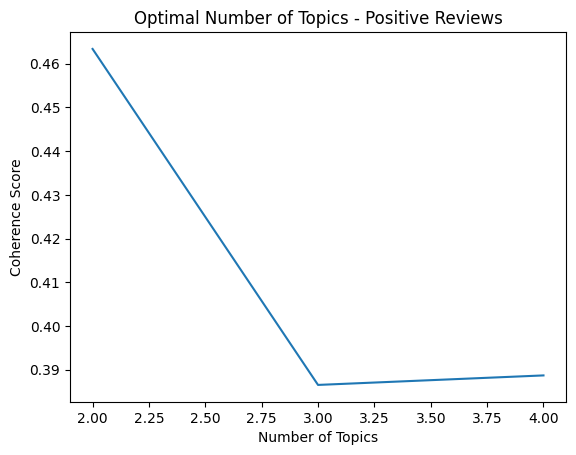

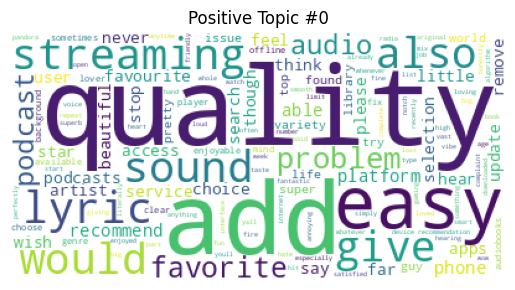

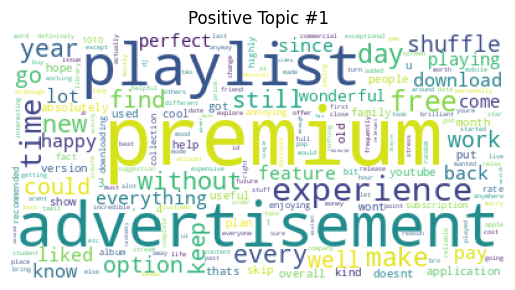

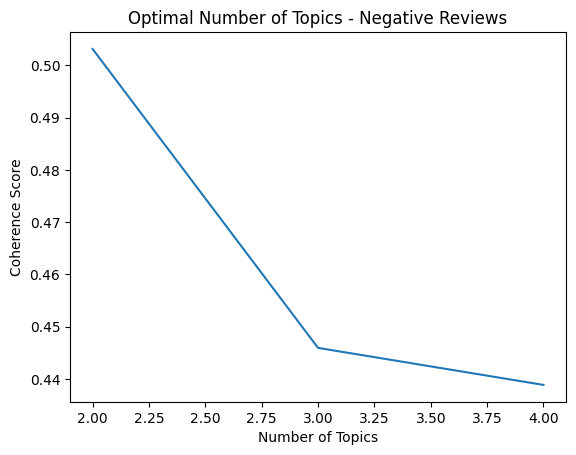

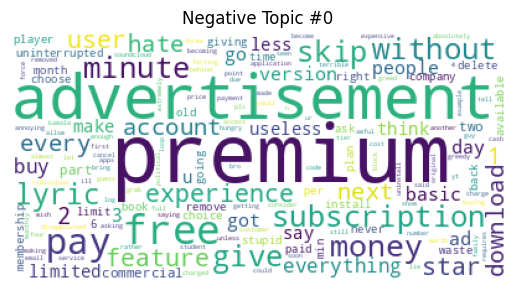

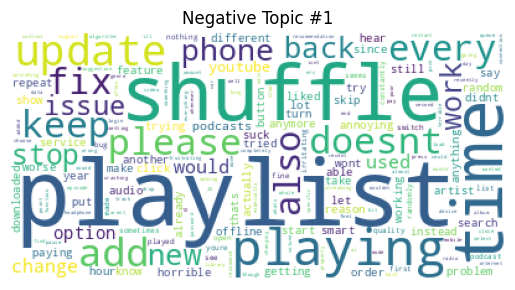

In [13]:
# Plot Coherence Scores
x = range(start, limit, step)
plt.figure()
plt.plot(x, coherence_values_pos)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Optimal Number of Topics - Positive Reviews")
plt.show()

# Visualize topics using word clouds
for t in range(n_positive_topics):
    plt.figure()
    plt.imshow(WordCloud(background_color='white').fit_words(dict(optimal_model_pos.show_topic(t, 200))))
    plt.axis("off")
    plt.title(f"Positive Topic #{t}")
    plt.show()

# Plot Coherence Scores
plt.figure()
plt.plot(x, coherence_values_neg)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Optimal Number of Topics - Negative Reviews")
plt.show()

# Visualize topics using word clouds
for t in range(n_negative_topics):
    plt.figure()
    plt.imshow(WordCloud(background_color='white').fit_words(dict(optimal_model_neg.show_topic(t, 200))))
    plt.axis("off")
    plt.title(f"Negative Topic #{t}")
    plt.show()

In [ ]:
# Export positive reviews for each topic
for topic_num in positive_reviews['Dominant_Topic'].unique():
    topic_df = positive_reviews[positive_reviews['Dominant_Topic'] == topic_num]
    topic_df.to_csv(f'positive_reviews_topic_{topic_num}.csv', index=False)

# Export negative reviews for each topic
for topic_num in negative_reviews['Dominant_Topic'].unique():
    topic_df = negative_reviews[negative_reviews['Dominant_Topic'] == topic_num]
    topic_df.to_csv(f'negative_reviews_topic_{topic_num}.csv', index=False)
